## 範例重點
* 學習如何在 keras 中加入 model checkpoint
* 知道如何設定監控目標
* 比較使用最佳與非最佳參數時的 performance

In [1]:
import os
from tensorflow import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 - Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896 

In [6]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型

參數說明：
filepath: 儲存模型的路徑與檔名
mointor: 以什麼指標作為判斷標準
save_best_only: 是否只要儲存最好的


"""
from keras.callbacks import ModelCheckpoint

save_dir = "./checkpoint"
file_name = save_dir + "/D86.h5"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_ckpt = ModelCheckpoint(filepath=file_name, 
                             monitor="val_loss", 
                             save_best_only=True)

In [8]:
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(x_test, y_test), 
                    shuffle=True,
                    callbacks=[model_ckpt], 
                    verbose=2)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model = keras.models.load_model(file_name)
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

Epoch 1/50
49/49 - 5s - loss: 2.2398 - accuracy: 0.2691 - val_loss: 2.1792 - val_accuracy: 0.1813 - 5s/epoch - 107ms/step
Epoch 2/50
49/49 - 3s - loss: 1.7509 - accuracy: 0.3943 - val_loss: 2.0022 - val_accuracy: 0.2778 - 3s/epoch - 70ms/step
Epoch 3/50
49/49 - 4s - loss: 1.6233 - accuracy: 0.4345 - val_loss: 1.8480 - val_accuracy: 0.3584 - 4s/epoch - 74ms/step
Epoch 4/50
49/49 - 3s - loss: 1.5479 - accuracy: 0.4616 - val_loss: 1.7243 - val_accuracy: 0.4087 - 3s/epoch - 69ms/step
Epoch 5/50
49/49 - 4s - loss: 1.4926 - accuracy: 0.4809 - val_loss: 1.6369 - val_accuracy: 0.4363 - 4s/epoch - 72ms/step
Epoch 6/50
49/49 - 4s - loss: 1.4463 - accuracy: 0.4988 - val_loss: 1.5841 - val_accuracy: 0.4474 - 4s/epoch - 77ms/step
Epoch 7/50
49/49 - 4s - loss: 1.4092 - accuracy: 0.5105 - val_loss: 1.5506 - val_accuracy: 0.4545 - 4s/epoch - 75ms/step
Epoch 8/50
49/49 - 4s - loss: 1.3724 - accuracy: 0.5238 - val_loss: 1.5158 - val_accuracy: 0.4723 - 4s/epoch - 77ms/step
Epoch 9/50
49/49 - 4s - loss: 1

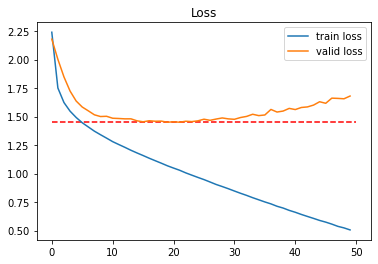

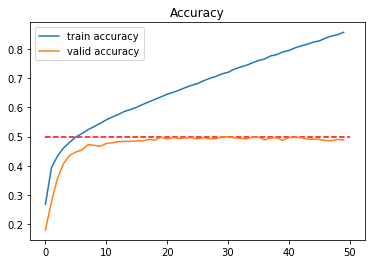

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test